<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
<center>Автор материала: Ольга Дайховская

# <center> Домашнее задание № 4. Часть 2
## <center>  Прогнозирование популярности статей на TechMedia с помощью линейных моделей

**В задании Вам предлагается разобраться с тем, как работает TfidfVectorizer и DictVectorizer, затем обучить и настроить модель линейной регрессии Ridge на данных о публикациях на Хабрахабре. Пройдя все шаги, вы сможете получить бейзлайн для [соревнования](https://inclass.kaggle.com/c/howpop-habrahabr-favs-lognorm). 
Ответьте на все вопросы в этой тетрадке и заполните ответы в [гугл-форме](https://docs.google.com/forms/d/e/1FAIpQLSd8E7naU38ikc9-rd31KeVfez3emCo4Ok1WrpQTr-XCDelRiw/viewform).**

**Описание соревнования**

Предскажите, как много звездочек наберет статья, зная только ее текст и время публикации

Необходимо предсказать популярность поста на Хабре по содержанию и времени публикации. Как известно, пользователи Хабра могут добавлять статьи к себе в избранное. Общее количество пользователей, которое это сделали отображается у статьи количеством звездочек. Будем считать, что число звездочек, поставленных статье, наиболее хорошо отражает ее популярность.

Более формально, в качестве метрики популярности статьи будем использовать долю статей за последний месяц, у которых количество звездочек меньше чем у текущей статьи. А точнее, доле числа звездочек можно поставить в соответствие квантили стандартного распределения, таким образом получаем числовую характеристику популярности статьи. Популярность статьи 0 означает, что статья получила ровно столько звездочек, сколько в среднем получают статьи. И соответственно чем больше звездочек получила статья по сравнению со средним, тем выше это число.

**Приступим:** импортируем необходимые библиотеки и скачаем данные

In [7]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer

#В зависимости от версии sklearn
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import numpy as np
import scipy

%matplotlib inline
from matplotlib import pyplot as plt

from wordcloud import WordCloud

from nltk.corpus import stopwords

In [2]:
train_df = pd.read_csv('../../data/howpop_train.csv')
test_df  = pd.read_csv('../../data/howpop_test.csv')

In [3]:
train_df.head(3).T

,0,1,2
url,https://habrahabr.ru/post/18284/,https://habrahabr.ru/post/18285/,https://habrahabr.ru/post/18286/
domain,habrahabr.ru,habrahabr.ru,habrahabr.ru
post_id,18284,18285,18286
published,2008-01-01 18:19:00,2008-01-01 18:30:00,2008-01-01 18:34:00
author,@Tapac,@DezmASter,@DezmASter
flow,develop,design,design
polling,False,False,False
content_len,4305,7344,8431
title,Новогодний подарок блоггерам — WordPress 2.3.2,"Сумасшедшие яйца, или сервис для отслеживания ...","Сумасшедшие яйца, или сервис для отслеживания ..."
comments,0,1,47


In [8]:
stops = stopwords.words('russian')

In [21]:
titles = train_df['title'].astype('str')
titles.head()

0       Новогодний подарок блоггерам — WordPress 2.3.2
1    Сумасшедшие яйца, или сервис для отслеживания ...
2    Сумасшедшие яйца, или сервис для отслеживания ...
3       Сглаживание шрифтов, и субпиксельная отрисовка
4                        Почему мне не нравится iPhone
Name: title, dtype: object

In [22]:
titles = titles.apply(lambda x: x.lower())

In [23]:
titles = titles.apply(lambda x: ' '.join([word for word in x.split() if not word in stops]))

In [24]:
titles

0            новогодний подарок блоггерам — wordpress 2.3.2
1         сумасшедшие яйца, сервис отслеживания посетителей
2         сумасшедшие яйца, сервис отслеживания посетителей
3              сглаживание шрифтов, субпиксельная отрисовка
4                                    почему нравится iphone
5                            mobile2.0 всеобщая доступность
6                                          modbook действии
7                                  суть проекта vladelia.ru
8         подтверждено: wikia search запускается понедел...
9          mobile 2.0 выбор предпочтительного способа связи
10                                обзор «лаунчеров» windows
11                                           онлайн банкинг
12                               оформление рабочего места.
13                              новые скриншоты cairo shell
14                                   шанс альтернативных ос
15           должен писать js код процессе работы проектом?
16        top-10 западных стартапов, кот

(-0.5, 1439.5, 1079.5, -0.5)

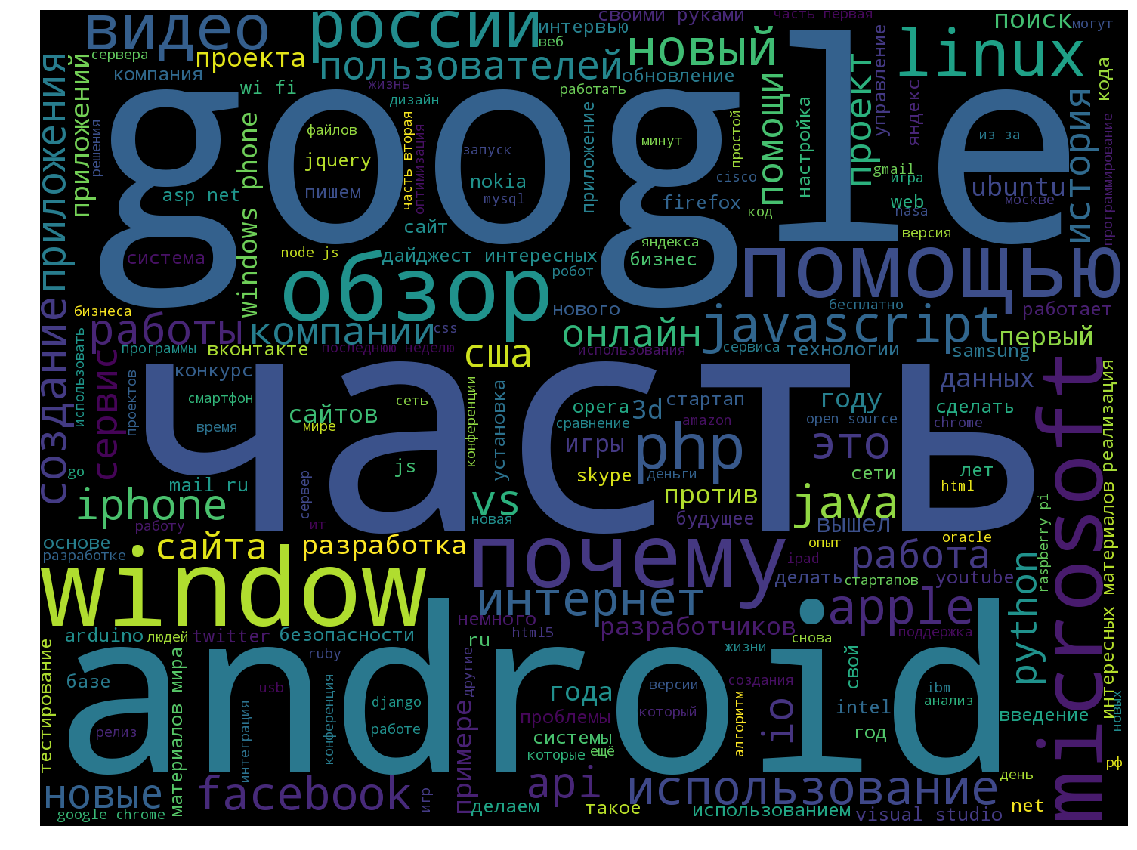

In [25]:
cloud = WordCloud(width=1440, height=1080).generate(" ".join(titles))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')